In [287]:
import logging
import warnings
import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)


In [288]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

from matplotlib.colors import ListedColormap

In [289]:
case = 'RES CAP BAT 4'
case_path = 'res_cap_bat_4'

In [290]:
path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/'
path_name = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/results_RCB_4/res_cap_bat_store_'
path_fig = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/figures_' + case_path + '/'
years = [2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034]
networks = [pypsa.Network(path_name + str(year) + '.nc') for year in years]
networks = dict(zip(years, networks))
first_year = years[0]
final_year = years[-1]

In [291]:
save_to_csv = True
all_saved = False

In [292]:
# Helper functions
# def get_power_prod(year):
#     network = networks[year]
#     carrier_list = network.generators.carrier.unique()
#     carrier_list_2 = network.storage_units.carrier.unique()
#     carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
#     production_data = {}
#     first_date = "2013-01-01"
#     second_date = "2013-12-31"
#     for carrier in carriers:
#         production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6

#     df = pd.DataFrame([production_data])
#     df['hydro'] += df.pop('ror')
#     return df

def get_power_prod(year):
    network = networks[year]
    carrier_list = network.generators.carrier.unique()
    carrier_list_2 = network.storage_units.carrier.unique()
    carriers = np.concatenate((carrier_list, carrier_list_2), axis=None)
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    # for carrier in carriers:
    #     production_data[carrier] = get_snapshot_generation(year, first_date, second_date, carrier).sum() /1e6
 
    production_data["CCGT"] = get_snapshot_generation(year, first_date, second_date, "CCGT").sum() /1e6
    production_data["OCGT"] = get_snapshot_generation(year, first_date, second_date, "OCGT").sum() /1e6
    production_data["oil"] = get_snapshot_generation(year, first_date, second_date, "oil").sum() /1e6
    #production_data["geothermal"] = get_snapshot_generation(year, first_date, second_date, "geothermal").sum() /1e6
    production_data["hydro"] = get_snapshot_generation(year, first_date, second_date, "hydro").sum() /1e6
    production_data["onwind"] = get_snapshot_generation(year, first_date, second_date, "onwind").sum() /1e6
    production_data["solar"] = get_snapshot_generation(year, first_date, second_date, "solar").sum() /1e6
    production_data["biomass"] = get_snapshot_generation(year, first_date, second_date, "biomass").sum() /1e6
    production_data["ror"] = get_snapshot_generation(year, first_date, second_date, "ror").sum() /1e6
    production_data["load"] = get_snapshot_generation(year, first_date, second_date, "load").sum() /1e6
 
    df = pd.DataFrame([production_data])
    df['hydro'] += df.pop('ror')
    return df

def get_bus(bus_name, bus_info):
    if bus_name == bus_info['Bus']:
        return bus_info['x'], bus_info['y']

def get_demand(year): 
    network = networks[year]
    el_demand =network.loads_t.p_set
    regional_demand = pd.DataFrame(el_demand.sum()/1000000)
    return regional_demand.sum()

def total_production(year):
    prod = pd.DataFrame(get_power_prod(year))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(year):
    total_prod = total_production(year)
    prod = get_power_prod(year)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    df.index = [year]  
    return df

def get_max_output(year):
    network = networks[year]
    return network.generators.groupby(by='carrier')["p_max_pu"].sum()

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

def get_objective(year):
    network = networks[year]
    return network.objective /1e6

def get_total_cost(year):
    network = networks[year]
    return (network.statistics.capex().sum() + network.statistics.opex().sum())/1e6

def get_emissions(year):
    network = networks[year]
    emissions = network.generators_t.p / network.generators.efficiency * network.generators.carrier.map(network.carriers.co2_emissions)
    return emissions.sum().sum() / 1000000

def get_installed_capacity(year):
    network = networks[year]

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()
    capacities_df.index = [year]

    return capacities_df

def get_installed_capacity_charge(year):
    network = networks[year]
    capacities_discharge = network.links.groupby(by='carrier')['p_nom'].sum()
    capacities_discharge_df = capacities_discharge.to_frame().transpose()
    capacities_discharge_df.index = [year]
    return capacities_discharge_df

def get_installed_capacity_battery(year):
    network = networks[year]
    storage_capacity = network.stores.groupby(by='carrier')['e_nom'].sum()
    storage_capacity_df = storage_capacity.to_frame().transpose()
    storage_capacity_df.index = [year]
    return storage_capacity_df

def get_snapshot_generation(year, first_date, second_date, carrier):
    network = networks[year]
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(year, first_date, second_date):
    network = networks[year]
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_cap_cost(year):
    network = networks[year]
    capital_cost = network.generators.groupby('carrier').capital_cost.mean().drop('load')
    return capital_cost

def get_new_installed(years):
    data_agg=pd.DataFrame({})
    for y in years:
        net = networks[y]

        capacity=pd.DataFrame(net.generators)
        capacity
        hydro=pd.DataFrame(net.storage_units)[["p_nom_opt","carrier","p_nom"]]
        caps=pd.concat([capacity[["p_nom_opt","carrier","p_nom"]],hydro],ignore_index=True)
        caps["zubau"]=caps["p_nom_opt"]-caps["p_nom"]
        caps["year"]=np.ones(len(caps["p_nom_opt"]),dtype=int)*y
        
        data_agg=pd.concat([data_agg,caps[["year","carrier","zubau"]]])
        
    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() 

    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    grouped_cap_change_B = grouped_cap_change_B.drop('load', axis=1)
    grouped_cap_change_B['hydro'] += grouped_cap_change_B.pop('ror')

    return grouped_cap_change_B

def get_new_installed_battery(years):
    capacity = {'Charger':[], 'Discharger':[],'Battery Storage':[], 'year':[]}

    for y in years:
        net=networks[y]

        capacity["year"].append(y)

        charger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery charger', 0)
        charger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery charger', 0)
        capacity['Charger'].append(charger_next_capacity-charger_capacity)

        discharger_capacity = net.links.groupby('carrier').p_nom.sum().get('battery discharger', 0)
        discharger_next_capacity = net.links.groupby('carrier').p_nom_opt.sum().get('battery discharger', 0)
        capacity['Discharger'].append(discharger_next_capacity-discharger_capacity)

        battery_storage_capacity = net.stores.groupby('carrier').e_nom.sum().get('battery', 0)
        battery_storage_next_capacity = net.stores.groupby('carrier').e_nom_opt.sum().get('battery', 0)
        capacity['Battery Storage'].append(battery_storage_next_capacity-battery_storage_capacity)

    capacity_battery_df = pd.DataFrame(capacity)
    capacity_battery_df.set_index("year", inplace=True)

    return capacity_battery_df

def get_new_installed_lines(years):
    capacity = {'year':[], 'Line':[]}

    for y in years:
        if y != final_year:
            net=networks[y]
            net2=networks[y+1]
            yearly_capacity_change = 0

            for line in net.lines.index:
                if line in net2.lines.index:
                    yearly_capacity_change += net2.lines.loc[line].s_nom - net.lines.loc[line].s_nom
            
            capacity['year'].append(y)
            capacity['Line'].append(yearly_capacity_change)

    capacity_lines_df = pd.DataFrame(capacity)
    capacity_lines_df.set_index("year", inplace=True)
      
    return capacity_lines_df

def rename_columns(df):
    new_names = ['Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Geothermal', 'Battery']
    old_names = ['biomass', 'oil', 'onwind', 'solar', 'hydro', 'geothermal', 'battery']
    name_map= dict(zip(old_names, new_names))
    df = df.rename(columns=name_map)
    return df

def get_colors(carriers):
    colors = [beige2, beige3, green2, beige1, teal4, yellow, teal2, brown, brown2]
    names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro', 'Battery', 'Geothermal']
    color_dict = dict(zip(names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_marginal_cost(y, carrier):
    network = networks[y]
    marginal_cost= network.generators.loc[network.generators['carrier'] == carrier, 'marginal_cost'].iloc[0]
    return marginal_cost

def get_subsidies():
    actual_cost = {'CCGT': 52.00, 'OCGT': 64.71, 'oil': 130.23}
    subsidies = {}
    for y in years:
        for carrier in ['CCGT', 'OCGT', 'oil']:
            marginal_cost= get_marginal_cost(y, carrier)
            subsidies[(y, carrier)] = actual_cost[carrier] - marginal_cost
    return subsidies

def npv_of_costs(annual_costs, discount_rate):
    return sum(annual_cost / (1 + discount_rate) ** i for i, annual_cost in enumerate(annual_costs))

def calculate_present_value(future_value, year, base_year, discount_rate):
    return future_value / ((1 + discount_rate) ** (year - base_year))


def capital_recovery_factor(lifetime, discount_rate):
    return discount_rate / (1 - (1 + discount_rate) ** -lifetime)

def annual_capex(years):
    capex_df = pd.DataFrame(index=years, columns=['Capex'])
    new_installed_cap = get_new_installed(years)
    new_installed_bat = get_new_installed_battery(years)
    new_installed_lines = get_new_installed_lines(years)
    for y in years:
        installed_cap = get_installed_capacity(y)
        installed_bat = get_installed_capacity_battery(y)
        installed_charge = get_installed_capacity_charge(y)
        network = networks[y]
        total_capex = 0

        for carrier in new_installed_cap.columns:
            if carrier != 'hydro':
                capex_value = new_installed_cap.loc[y, carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
                total_capex += capex_value
        for carrier in installed_cap.columns:
            if carrier == 'hydro':
                capex_value = installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == 'ror', 'capital_cost'].iloc[0]
                total_capex += capex_value
            else:
                capex_value = installed_cap.loc[y,carrier] * network.generators.loc[network.generators['carrier'] == carrier, 'capital_cost'].iloc[0]
                total_capex += capex_value
        total_capex += installed_bat.loc[y, 'battery'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        total_capex += installed_charge.loc[y, 'battery charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        total_capex += new_installed_bat.loc[y, 'Battery Storage'] * network.stores.loc[network.stores['carrier'] == 'battery', 'capital_cost'].iloc[0]
        total_capex += new_installed_bat.loc[y, 'Charger'] * network.links.loc[network.links['carrier'] == 'battery charger', 'capital_cost'].iloc[0]
        
        if y != final_year:
            total_capex += new_installed_lines.loc[y, 'Line']

        capex_df.loc[y, 'Capex'] = total_capex
    return capex_df #EUR

def capacity_factors(year):
    carrier_mapping = {
        'Biomass': 'biomass',
        'Combined-Cycle Gas': 'CCGT',
        'Oil': 'oil',
        'Onshore Wind': 'onwind',
        'Open-Cycle Gas': 'OCGT',
        'Solar': 'solar',
        'Run of River': 'hydro'
    }

    network = networks[year]
    network_stats = network.statistics()
    cp = {output: [] for output in carrier_mapping.values()}

    for carrier_stat, carrier in carrier_mapping.items():
        value = network_stats.loc['Generator']['Capacity Factor'].drop('load')[carrier_stat]
        cp[carrier] = value

    return cp

In [293]:
gens = networks[2021].generators

In [294]:
networks[2021].generators_t

{'p_min_pu': Empty DataFrame
 Columns: []
 Index: [2013-01-01 00:00:00, 2013-01-01 01:00:00, 2013-01-01 02:00:00, 2013-01-01 03:00:00, 2013-01-01 04:00:00, 2013-01-01 05:00:00, 2013-01-01 06:00:00, 2013-01-01 07:00:00, 2013-01-01 08:00:00, 2013-01-01 09:00:00, 2013-01-01 10:00:00, 2013-01-01 11:00:00, 2013-01-01 12:00:00, 2013-01-01 13:00:00, 2013-01-01 14:00:00, 2013-01-01 15:00:00, 2013-01-01 16:00:00, 2013-01-01 17:00:00, 2013-01-01 18:00:00, 2013-01-01 19:00:00, 2013-01-01 20:00:00, 2013-01-01 21:00:00, 2013-01-01 22:00:00, 2013-01-01 23:00:00, 2013-01-02 00:00:00, 2013-01-02 01:00:00, 2013-01-02 02:00:00, 2013-01-02 03:00:00, 2013-01-02 04:00:00, 2013-01-02 05:00:00, 2013-01-02 06:00:00, 2013-01-02 07:00:00, 2013-01-02 08:00:00, 2013-01-02 09:00:00, 2013-01-02 10:00:00, 2013-01-02 11:00:00, 2013-01-02 12:00:00, 2013-01-02 13:00:00, 2013-01-02 14:00:00, 2013-01-02 15:00:00, 2013-01-02 16:00:00, 2013-01-02 17:00:00, 2013-01-02 18:00:00, 2013-01-02 19:00:00, 2013-01-02 20:00:00, 2013

In [295]:
stores = networks[2021].storage_units

In [296]:
networks[2021].statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                3.200000e-01         1.823225e+07   
            Combined-Cycle Gas     4.696000e-01         1.152150e+08   
            Oil                    2.850486e-08         4.488739e+05   
            Onshore Wind           1.323209e-01         1.391770e+07   
            Open-Cycle Gas         3.719522e-03         4.482182e+07   
            Run of River           5.000000e-01         9.822414e+07   
            Solar                  1.901270e-01         8.386148e+06   
            load                   3.851048e-15         0.000000e+00   
Line        AC                     9.092290e-02         5.094740e+07   
Link        battery charger        4.132529e-01         3.864647e-01   
            battery discharger     3.347348e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        5.000000e-01         0.000000e+00   
Store       Battery Storage        4.988098e-01         2.440381e-01   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  1.838339e+05        6.558000e+01   
            Combined-Cycle Gas     0.000000  5.611040e+06        1.363990e+03   
            Oil                    0.000000  2.931509e-03        1.174000e+01   
            Onshore Wind           0.122494  1.476037e+05        1.273400e+02   
            Open-Cycle Gas         0.000000  3.091867e+04        9.489200e+02   
            Run of River           0.000000  1.587881e+06        3.625300e+02   
            Solar                  0.088463  2.746430e+05        1.649000e+02   
            load                   0.000000  1.349407e-04        4.000000e+09   
Line        AC                          NaN  3.009920e+06        3.811620e+03   
Link        battery charger             NaN -3.633139e-02        0.000000e+00   
            battery discharger          NaN -3.269825e-02        0.000000e+00   
Load        -                           NaN -9.455076e+06                 NaN   
StorageUnit Reservoir & Dam        0.000000  1.619155e+06        3.696700e+02   
Store       Battery Storage             NaN  0.000000e+00        0.000000e+00   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             1.398383e+01             3.945092e+05   
            Combined-Cycle Gas  1.402274e+01             7.786017e+07   
            Oil                 1.399367e+01             1.125085e-01   
            Onshore Wind        1.395791e+01             3.727942e+03   
            Open-Cycle Gas      1.569478e+01             4.852618e+05   
            Run of River        1.398383e+01             1.622962e+04   
            Solar               1.389057e+01             5.505643e+03   
            load                1.398478e+04             1.362774e-01   
Line        AC                  1.735469e-08                      NaN   
Link        battery charger     9.967655e-01             0.000000e+00   
            battery discharger  1.830075e+00             0.000000e+00   
Load        -                  -1.400940e+01                      NaN   
StorageUnit Reservoir & Dam     1.398383e+01             1.653882e+04   
Store       Battery Storage              inf             5.029258e-22   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass                 6.558000e+01  2.570702e+06  1.838339e+05   
            Combined-Cycle Gas      1.363990e+03  7.868214e+07  5.611040e+06   
            Oil                     1.174000e+01  4.102258e-02  2.931509e-03   
            O

In [297]:
cp_years = {year: capacity_factors(year) for year in years}
cp_df = pd.DataFrame.from_dict(cp_years, orient='index').stack().reset_index()
cp_df.columns = ['Year', 'Carrier', 'CapacityFactor']
cp_df_pivot = cp_df.pivot(index='Year', columns='Carrier', values='CapacityFactor')

if save_to_csv:
    cp_df_pivot.to_csv(path + 'result_data_RCB/' + case_path + '_capacity_factors.csv')

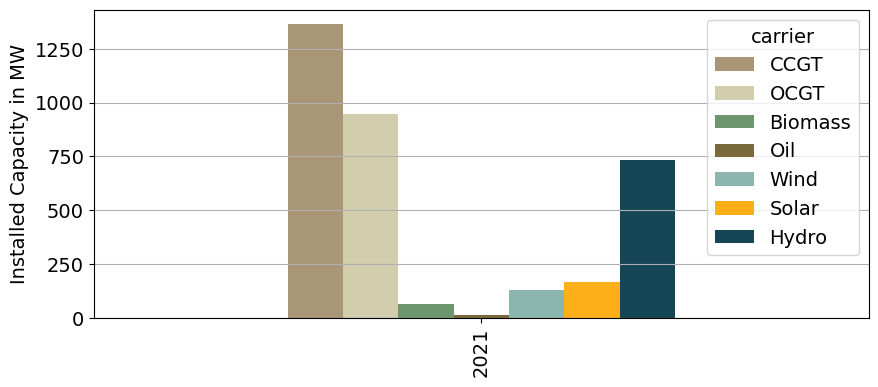

In [298]:
installed_capacity_23 = get_installed_capacity(first_year)
installed_capacity_23.index = [first_year]
installed_capacity_23 = rename_columns(installed_capacity_23)
installed_capacity_23.plot(kind='bar',color=get_colors(installed_capacity_23.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
#plt.ylim(0,5500)
plt.grid(axis='y')
plt.show()

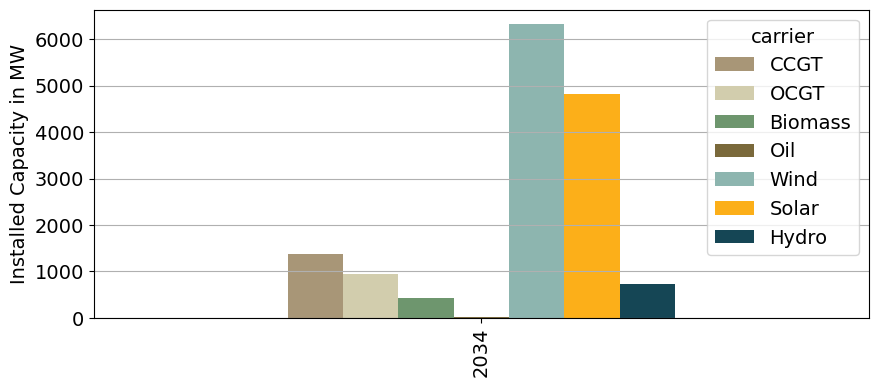

In [299]:
installed_capacity_37 = get_installed_capacity(final_year)
installed_capacity_37.index = [final_year]
installed_capacity_37 = rename_columns(installed_capacity_37)
if save_to_csv:
    installed_capacity_37.to_csv(path + 'result_data_RCB/' + case_path + '_final_capacity.csv')
installed_capacity_37.plot(kind='bar',color=get_colors(installed_capacity_37.columns),figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.grid(axis='y')
#plt.ylim(0,5500)
plt.show()

In [300]:
yearly_difference = False
if yearly_difference:
    installed_capacities = []
    for year in years:
        year_capacity_df = get_installed_capacity(year)
        installed_capacities.append(year_capacity_df)

    all_capacities = pd.concat(installed_capacities)
    year_over_year_diff = all_capacities.diff().dropna()
    year_over_year_diff = rename_columns(year_over_year_diff)

    year_over_year_diff.plot(kind='bar', figsize=(12, 6), color=get_colors(year_over_year_diff.columns))
    plt.title('Year-over-Year Differences in Installed Capacity')
    plt.ylabel('Difference in Installed Capacity (MW)')
    plt.xlabel('Year')
    #plt.ylim(0, 10)
    plt.show()

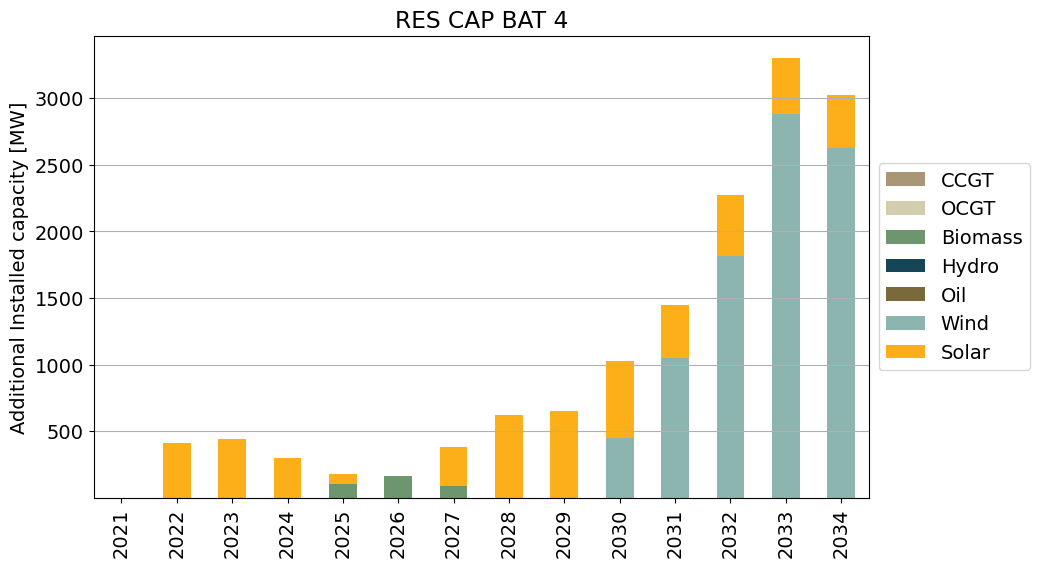

In [301]:
grouped_cap_change_B = get_new_installed(years)
grouped_cap_change_B = rename_columns(grouped_cap_change_B)
if save_to_csv:
    grouped_cap_change_B.to_csv(path + 'result_data_RCB/' + case_path + '_new_capacity.csv')
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6),color=get_colors(grouped_cap_change_B.columns), legend=True)

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.title(case)
#plt.ylim(0, 1200)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis = 'y',zorder = 0)
#plt.savefig(path_fig + 'new_capacity.png', dpi=300, bbox_inches='tight')

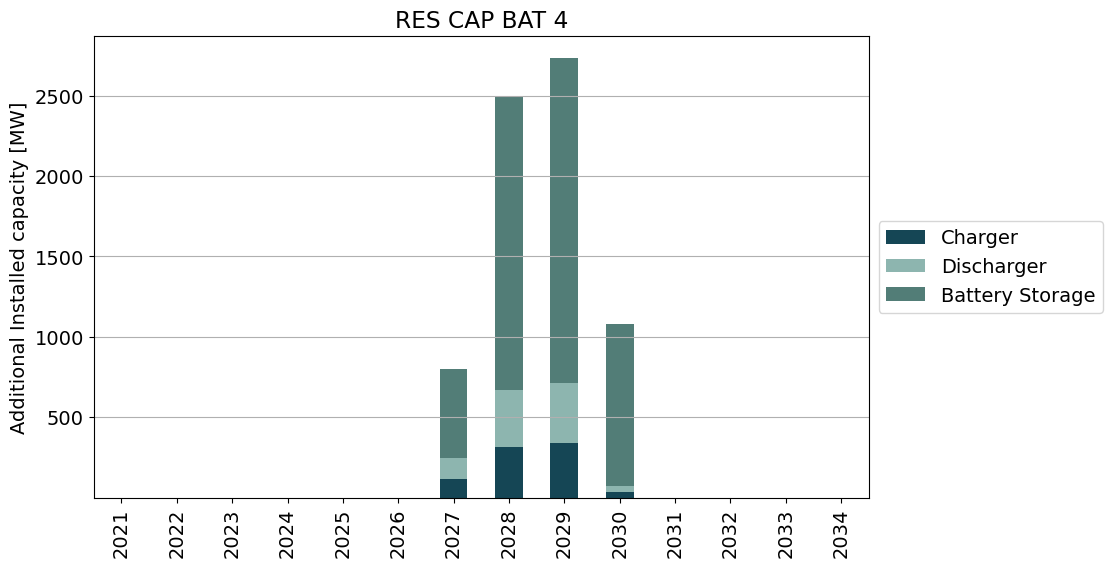

In [302]:
battery_change = get_new_installed_battery(years)
if save_to_csv:
    battery_change.to_csv(path + 'result_data_RCB/' + case_path + '_new_battery_capacity.csv')
#battery_change = rename_columns(battery_change)
battery_change.plot.bar(stacked=True, figsize=(10, 6),color=[teal2, teal4, teal3])

plt.ylabel('Additional Installed capacity [MW]')
plt.xlabel('')
plt.xticks(range(len(battery_change.index)), battery_change.index, rotation=90)
plt.title(case)
#plt.ylim(0, 13)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis = 'y',zorder = 0)
#plt.savefig(path_fig + 'new_battery_capacity.png', dpi=300, bbox_inches='tight')

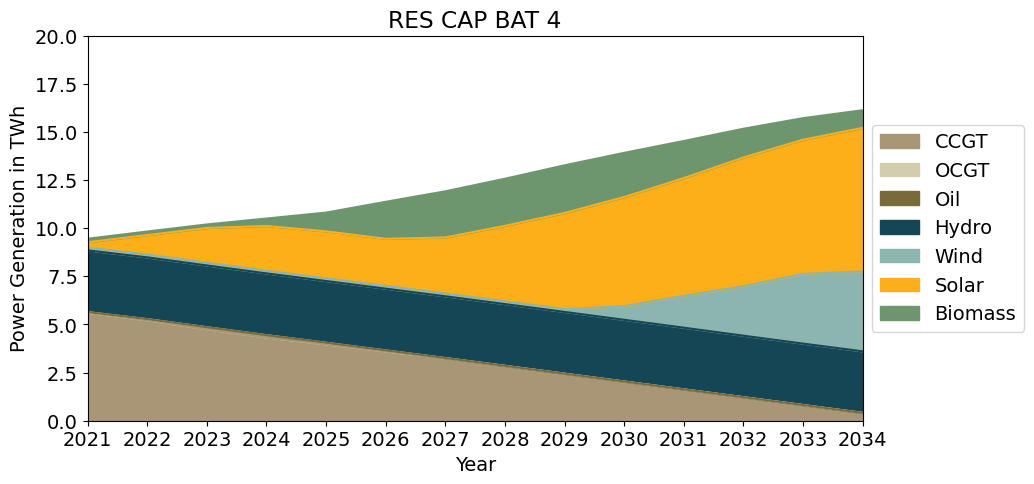

In [303]:
production_sources = [get_power_prod(year) for year in years]
production = pd.concat(production_sources)
production.index = years
production = production.astype('float32')

if 'load' in production:
  production.drop('load', axis=1, inplace=True)

#production['hydro'] += production.pop('ror')
#print(production)
production = rename_columns(production)
if save_to_csv:
  production.to_csv(path + 'result_data_RCB/' + case_path + '_production.csv')
production.plot.area(stacked=True, color=get_colors(production.columns),figsize=(10, 5))

plt.xticks(years, [int(year) for year in years])
plt.ylabel('Power Generation in TWh')
plt.xlabel('Year')
plt.xlim(first_year,final_year)
plt.ylim(0,20)
plt.title(case)
#plt.xticks(range(len(years)), years)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig(path_fig + 'power_generation.png', dpi=300, bbox_inches='tight')

          CCGT     OCGT           oil     hydro    onwind     solar   biomass
2021  0.593442  0.00327  3.100461e-10  0.339187  0.015611  0.029047  0.019443


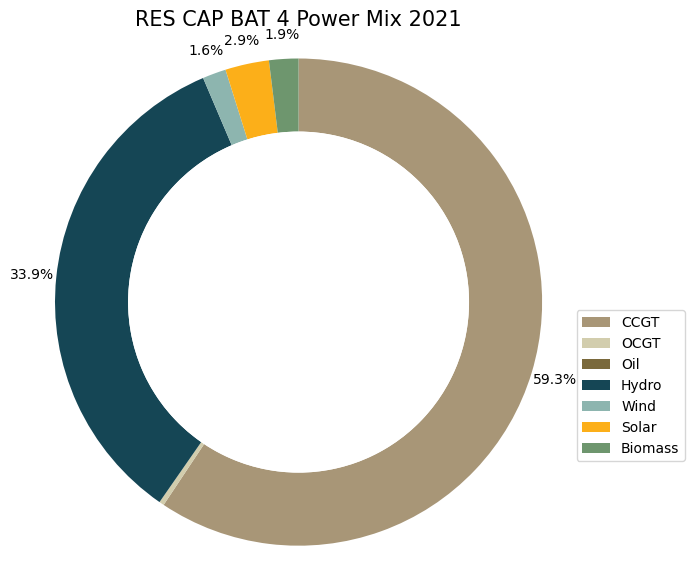

In [304]:
power_mix_df = get_power_mix(first_year)
print(power_mix_df)
plt.rcParams['font.size'] = 10
power_mix_df = rename_columns(power_mix_df)
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.1)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title(case + ' Power Mix '+ str(first_year), fontsize=15)
plt.legend(power_mix_df.columns, bbox_to_anchor=(1, 0.5))
plt.show()

          CCGT          OCGT           oil     hydro    onwind     solar  \
2034  0.025255  3.538106e-08  1.618961e-08  0.198261  0.257496  0.462141   

       biomass  
2034  0.056847  


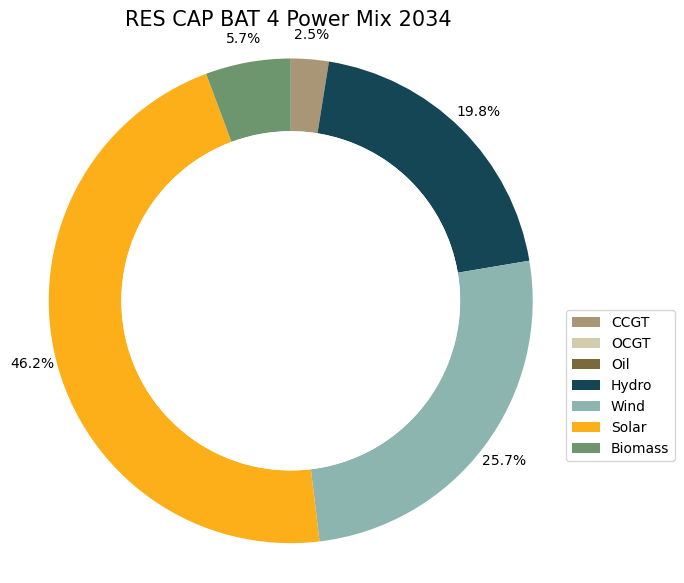

In [305]:
power_mix_df = get_power_mix(final_year)
print(power_mix_df)
plt.rcParams['font.size'] = 10
power_mix_df = rename_columns(power_mix_df)
if save_to_csv:
    try:
        df = pd.read_csv(path + 'result_data_RCB/power_mix_final.csv')
    except FileNotFoundError:
        df = pd.DataFrame()
    df[case_path] = power_mix_df.iloc[0]
    df.to_csv(path + 'result_data_RCB/power_mix_final.csv', index=False)
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, colors=get_colors(power_mix_df.columns), startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.1)

# Hide the zero-value autotexts
for autotext in autotexts:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

plt.title(case + ' Power Mix ' + str(final_year), fontsize=15)
plt.legend(power_mix_df.columns, bbox_to_anchor=(1, 0.5))
#plt.savefig(path_fig + 'power_mix_37.png', dpi=300, bbox_inches='tight')
plt.show()

          CCGT          OCGT           oil     hydro    onwind     solar  \
2034  0.025255  3.538106e-08  1.618961e-08  0.198261  0.257496  0.462141   

       biomass  
2034  0.056847  


Text(0.5, 0.98, 'RES CAP BAT 4')

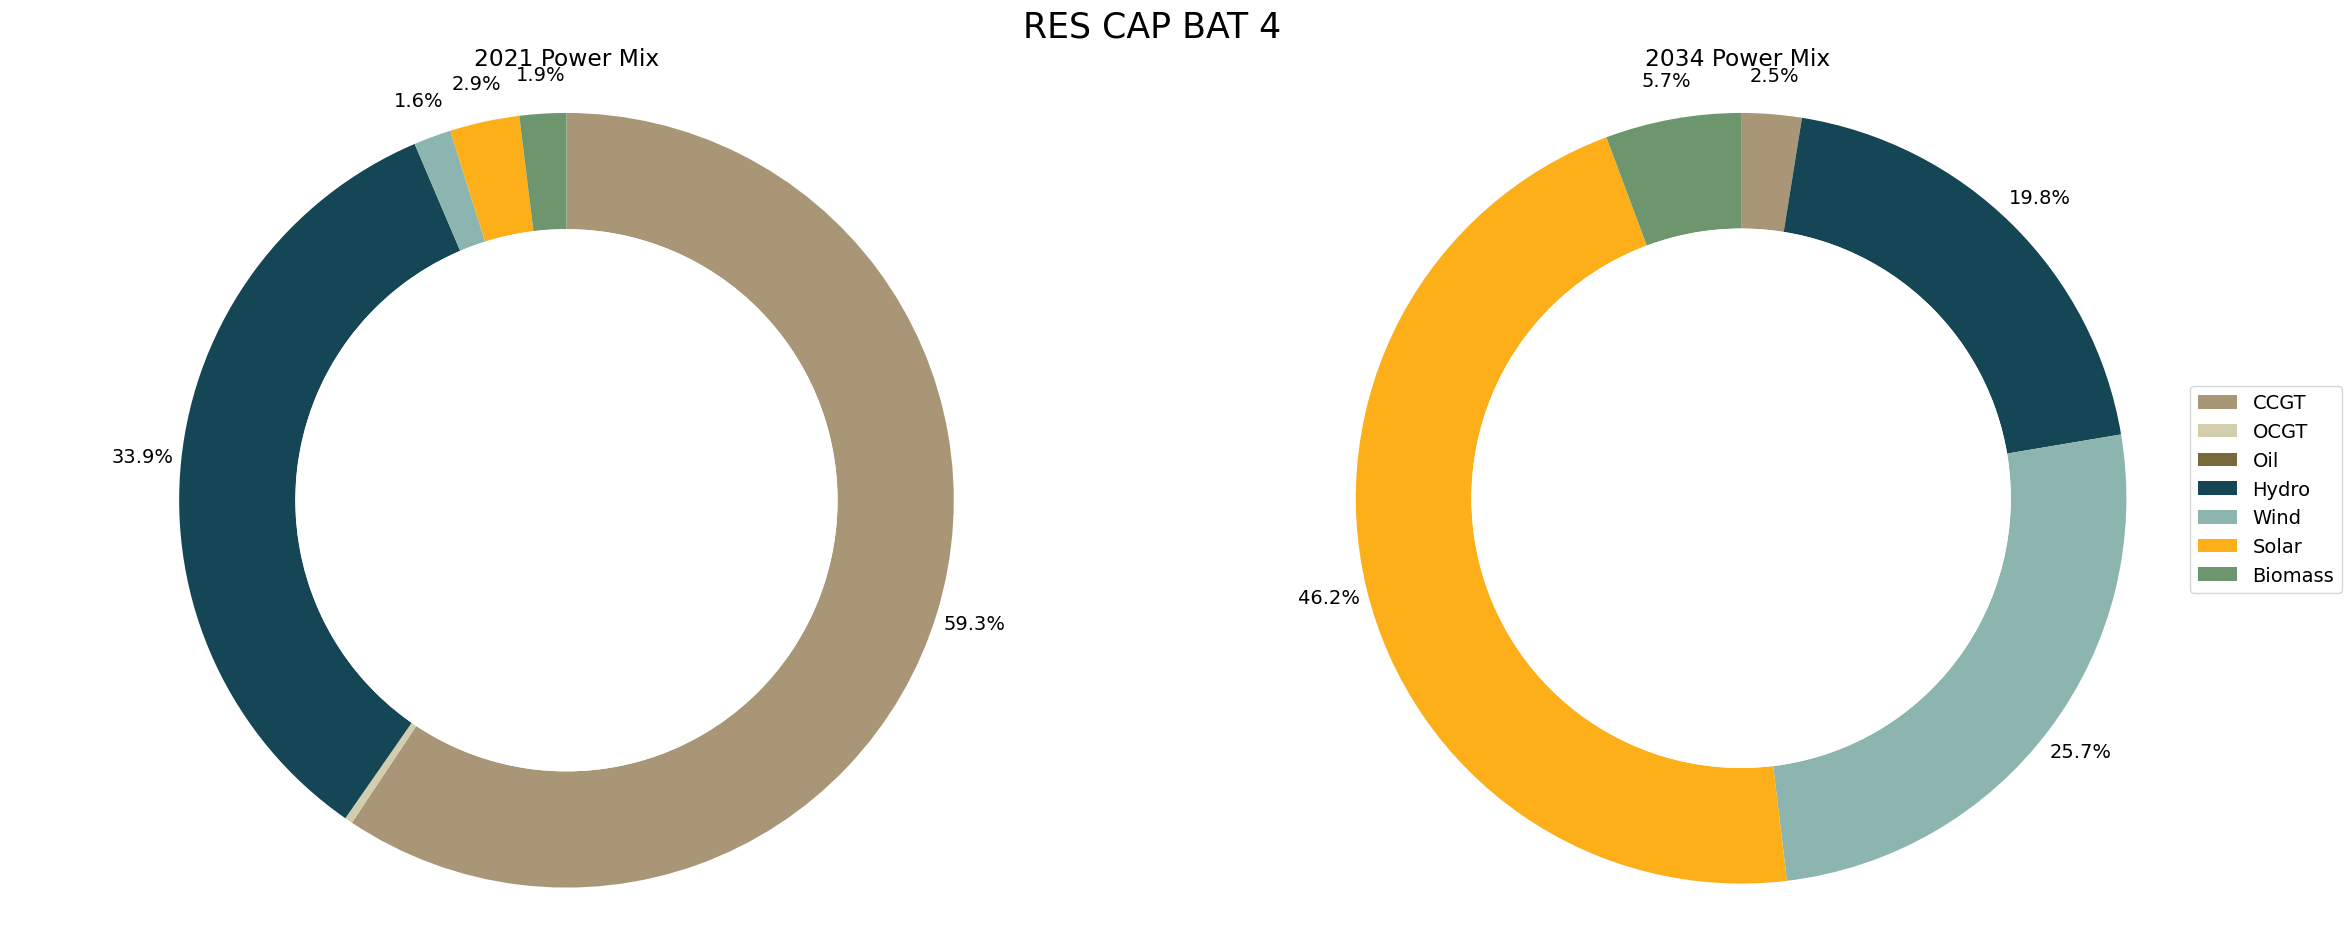

In [306]:
power_mix_first = get_power_mix(first_year)
power_mix_final = get_power_mix(final_year)
print(power_mix_final)

plt.rcParams['font.size'] = 14
power_mix_first = rename_columns(power_mix_first)
power_mix_final = rename_columns(power_mix_final)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

wedges1, texts1, autotexts1 = ax1.pie(
    power_mix_first.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_first.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.1
)

wedges2, texts2, autotexts2 = ax2.pie(
    power_mix_final.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(power_mix_final.columns), startangle=90, counterclock=False, 
    wedgeprops=dict(width=0.3), pctdistance=1.1
)

for autotext in autotexts1 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)

centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title(str(first_year) +' Power Mix')

centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title(str(final_year) +' Power Mix')

ax1.axis('equal')
ax2.axis('equal')

fig.legend(power_mix_first.columns, loc="center right", bbox_to_anchor=(1, 0.5))
plt.tight_layout(pad=3.0)
fig.suptitle(case, fontsize=25)
#plt.savefig(path_fig + 'power_mix.png', dpi=300, bbox_inches='tight')

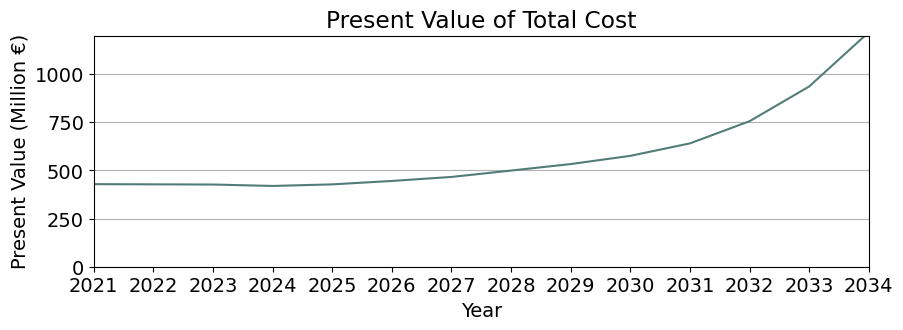

In [307]:
capex = [networks[year].statistics.capex().sum() / 1e6 for year in years]
opex = [networks[year].statistics.opex().sum() / 1e6 for year in years]

pv_capex = [calculate_present_value(cap, year, first_year, 0.04) for cap, year in zip(capex, years)]
pv_opex = [calculate_present_value(o, year, first_year, 0.04) for o, year in zip(opex, years)]

if save_to_csv:
    try:
        capex_df = pd.read_csv(path + 'result_data_RCB/capex.csv')
        opex_df = pd.read_csv(path + 'result_data_RCB/opex.csv')
    except FileNotFoundError:
        capex_df = pd.DataFrame()
        opex_df = pd.DataFrame()
    
    capex_df[case_path] = pv_capex
    opex_df[case_path] = pv_opex

    capex_df.to_csv(path + 'result_data_RCB/capex.csv', index=False)
    opex_df.to_csv(path + 'result_data_RCB/opex.csv', index=False)


total_pv = [pv_capex[i] + pv_opex[i] for i in range(len(years))]

plt.figure(figsize=(10, 3))
plt.plot(years, total_pv, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Present Value of Total Cost')
plt.xlabel('Year')
plt.ylabel('Present Value (Million €)')
plt.xlim(first_year,final_year)
plt.ylim(0,1200)
plt.grid(axis='y')
plt.show()

In [308]:
if save_to_csv:
    total_pv_df = pd.DataFrame(total_pv)
    try:
        df = pd.read_csv(path + 'result_data_RCB/total_costs.csv')
    except FileNotFoundError:
        df = pd.DataFrame()
    df[case_path] = total_pv_df.iloc[:]
    df.to_csv(path + 'result_data_RCB/total_costs.csv', index=False)

if all_saved:
    df = pd.read_csv(path + 'result_data_RCB/total_costs.csv')

    plt.figure(figsize=(10, 6)) 

    num_scenarios = len(df.columns)
    labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
    df.columns = labels
    colors = [beige2, beige3, teal4, teal3, teal2]

    for i, column in enumerate(df.columns):
        # Calculate the positions for the current column
        positions = range(i, len(df) * len(df.columns), len(df.columns))
        plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

    # Set the title and labels
    plt.title('Total Costs for Different Scenarios')
    plt.ylabel('Total Costs [billion €]')

    # Set x-ticks to be in the middle of the group of bars for each scenario
    tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
    plt.xticks(range(num_scenarios), df.columns)

    #plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,8)
    #plt.savefig(path_fig + 'total_cost.png', dpi=300, bbox_inches='tight')
    plt.show()
    
# else:
#     annual_costs_series.plot(kind='bar', figsize=(4, 4), color=teal2)
#     plt.ylabel('Total cost [billion €]')
#     #plt.ylim(0,18)
#     plt.xlabel('Base')
#     plt.grid(axis='y')
#     plt.savefig(path_fig + 'total_cost.png', dpi=300, bbox_inches='tight')

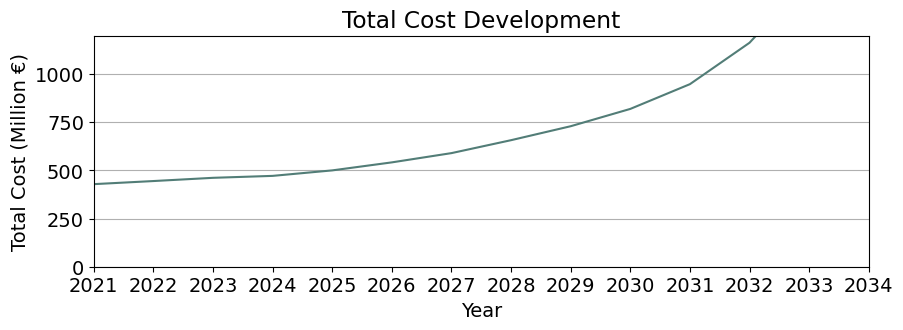

In [309]:
total_costs = [get_total_cost(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_costs, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Cost Development')
plt.xlabel('Year')
plt.ylabel('Total Cost (Million €)')
plt.xlim(first_year,final_year)
plt.ylim(0,1200)
plt.grid(axis='y')
plt.show()

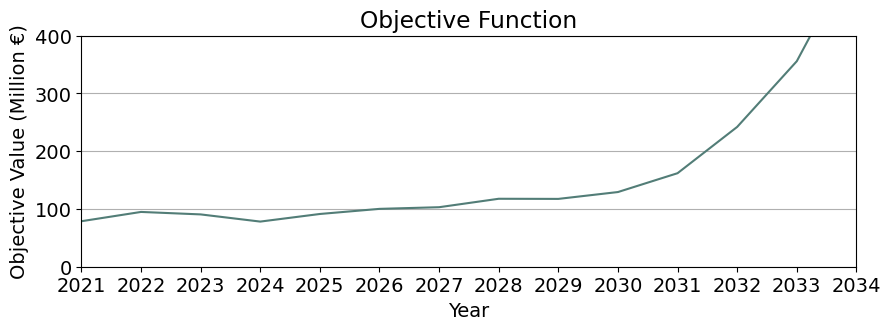

In [310]:
total_objective = [get_objective(year).sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_objective, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Objective Function')
plt.xlabel('Year')
plt.ylabel('Objective Value (Million €)')
plt.xlim(first_year,final_year)
plt.ylim(0,400)
plt.grid(axis='y')
plt.show()

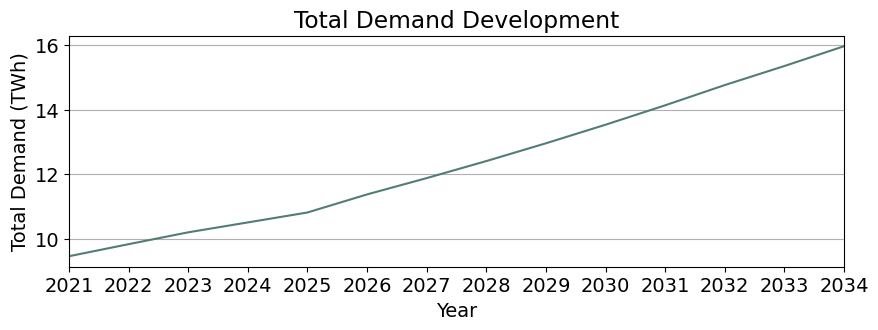

In [311]:
total_demand = [get_demand(year) for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_demand, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Total Demand Development')
plt.xlabel('Year')
plt.ylabel('Total Demand (TWh)')
plt.xlim(first_year,final_year)
plt.grid(axis='y')
plt.show()

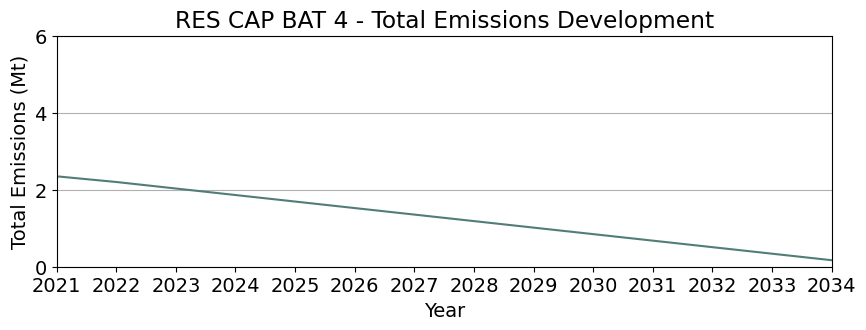

In [312]:
total_emissions = [get_emissions(year) for year in years]
if save_to_csv:
    total_emissions_df = pd.DataFrame({'Year': years, 'Emissions': total_emissions})

    try:
        # Try to read the existing file
        df = pd.read_csv(path + 'result_data_RCB/emissions.csv')
    except FileNotFoundError:
        # If file does not exist, create a new DataFrame
        df = pd.DataFrame()
  


    if case_path not in df.columns:
        df[case_path] = total_emissions_df['Emissions']
    df.to_csv(path + 'result_data_RCB/emissions.csv', index=False)


if all_saved:
    df = pd.read_csv(path + 'result_data_RCB/emissions.csv')
    df = df.set_index('Year')

    labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
    df.columns = labels
    colors = [beige2, beige3, teal4, teal3, teal2]

    plt.figure(figsize=(10, 6))  # Adjust the size as needed
    for column in df.columns:
        df[column].plot(label=column, color=colors[df.columns.get_loc(column)])
    plt.title('Emissions Over Years for Different Scenarios')
    plt.xlabel('Year')
    plt.ylabel('Emissions')
    plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,7)
    #plt.savefig(path_fig + 'emissions.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    plt.figure(figsize=(10, 3))
    plt.plot(years, total_emissions, color=teal3)
    plt.xticks(years, [int(year) for year in years])
    plt.title(case + ' - Total Emissions Development')
    plt.xlabel('Year')
    plt.ylabel('Total Emissions (Mt)')
    plt.xlim(first_year,final_year)
    plt.ylim(0,6)
    plt.grid(axis='y')
    #plt.savefig(path_fig + 'emissions.png', dpi=300, bbox_inches='tight')

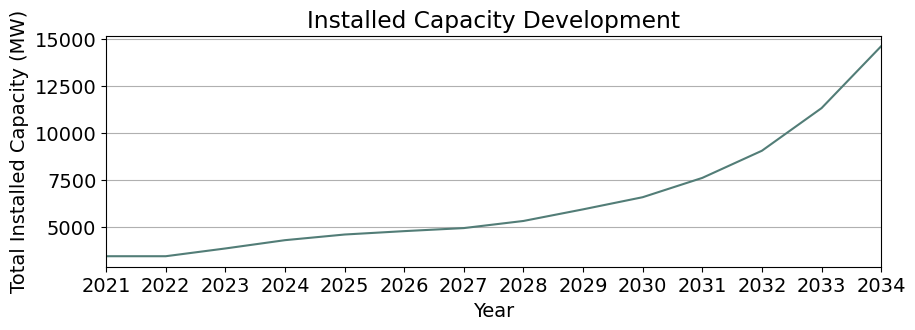

In [313]:
total_capacity = [get_installed_capacity(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

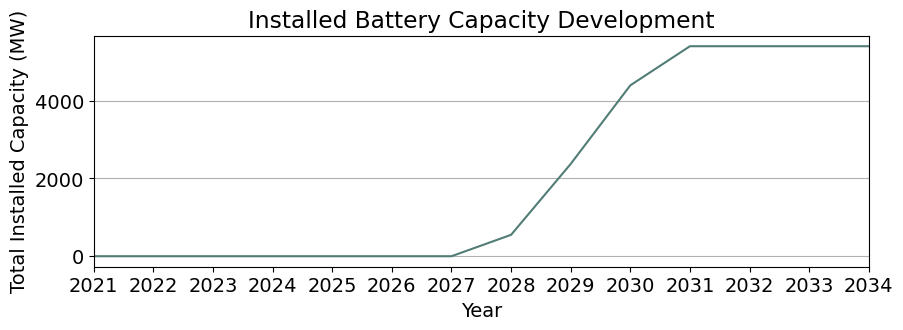

In [314]:
total_bat_capacity = [get_installed_capacity_battery(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_bat_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Battery Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

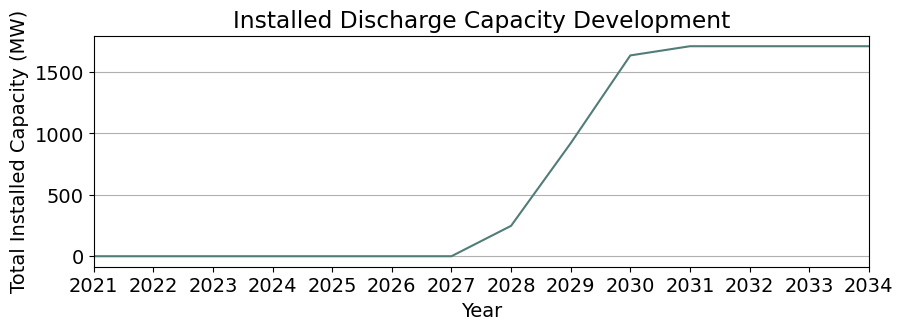

In [315]:
total_discharge_capacity = [get_installed_capacity_charge(year).sum().sum() for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, total_discharge_capacity, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Installed Discharge Capacity Development')
plt.xlabel('Year')
plt.ylabel('Total Installed Capacity (MW)')
plt.xlim(first_year,final_year)
#plt.ylim(0,6000)
plt.grid(axis='y')
plt.show()

Text(0.5, 1.0, 'RES CAP BAT 4 - 2037')

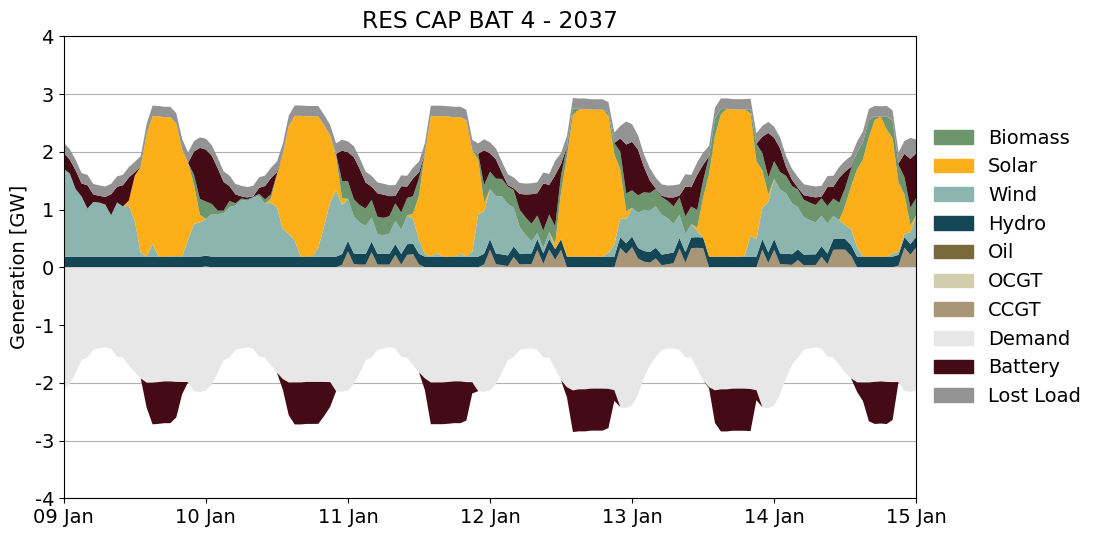

In [316]:
first_date = "2013-01-09"
second_date = "2013-01-15"
year = final_year

CCGT = get_snapshot_generation(year, first_date, second_date, 'CCGT')
OCGT = get_snapshot_generation(year, first_date, second_date, 'OCGT')
Oil = get_snapshot_generation(year, first_date, second_date, 'oil')
#Geothermal = get_snapshot_generation(year, first_date, second_date, 'geothermal')
#Hydro = get_snapshot_generation(year, first_date, second_date, 'ror')
Hydro = get_snapshot_generation(year, first_date, second_date, 'hydro')
Wind = get_snapshot_generation(year, first_date, second_date, 'onwind')
Solar = get_snapshot_generation(year, first_date, second_date, 'solar')
Biomass = get_snapshot_generation(year, first_date, second_date, 'biomass')
Battery = get_snapshot_generation(year, first_date, second_date, 'battery')
#H2 = get_snapshot_generation(year, first_date, second_date, 'H2')
demand = get_snapshot_demand(year, first_date, second_date)   

i=0
nbattery = []
pbattery =[]
for i in Battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in Battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 
nbattery_9 = [float(n) / 0.9 for n in nbattery]
pbattery_9 = [float(n) * 0.9 for n in pbattery]
LL = (demand.values + nbattery_9)*-1 - (CCGT + OCGT +Oil +Wind +Solar +Biomass +Hydro +pbattery_9 )

snapshots = {'CCGT': CCGT, 'OCGT': OCGT, 'Oil': Oil, 'Hydro': Hydro, 'Wind': Wind, 'Solar': Solar, 'Biomass': Biomass, 'Battery': pbattery, 'Nbattery': nbattery, 'Lost load': LL,'Demand': demand}
df_snapshots = pd.DataFrame(snapshots)
if save_to_csv:
    df_snapshots.to_csv(path + 'result_data_RCB/' + case_path + '_snapshots.csv')
#print('LL',LL.sum())

# print('CCGT: ', CCGT.sum())
# print('OCGT: ', OCGT.sum())
# print('Wind: ', Wind.sum())
# print('Solar: ', Solar.sum())
# print('Hydro: ', Hydro.sum())
# print('Oil: ', Oil.sum())
# print('Geothermal ',Geothermal.sum())
# print('Biomass: ', Biomass.sum())
# print('Battery: ', Battery.sum())
#print('H2: ', H2.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Hydro, Wind, Solar, Biomass, pbattery, LL,
                  colors=[beige2,beige3,beige1, teal2, teal4,yellow,green2, brown, grey4], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand,nbattery, colors=[grey1, brown], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-4000, 4000)


biomass_patch = mpatches.Patch(color = green2, label = 'Biomass')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
wind_patch = mpatches.Patch(color=teal4, label ='Wind')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
#geo_patch = mpatches.Patch(color = brown2, label = 'Geothermal')
oil_patch = mpatches.Patch(color=beige1, label = 'Oil')
OCGT_patch = mpatches.Patch(color=beige3, label ='OCGT')
CCGT_patch = mpatches.Patch(color=beige2, label ='CCGT')
load_patch = mpatches.Patch(color=grey1, label ='Demand')
battery_patch = mpatches.Patch(color=brown, label ='Battery')
LL_patch = mpatches.Patch(color=grey4, label ='Lost Load')
#H2_patch = mpatches.Patch(color=red2, label ='H2')
handles=[biomass_patch, solar_patch, wind_patch, hydro_patch, oil_patch, OCGT_patch, CCGT_patch, load_patch, battery_patch, LL_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)
plt.title(case + ' - 2037')
#plt.savefig(path_fig + 'snapshot.png', dpi=300, bbox_inches='tight')

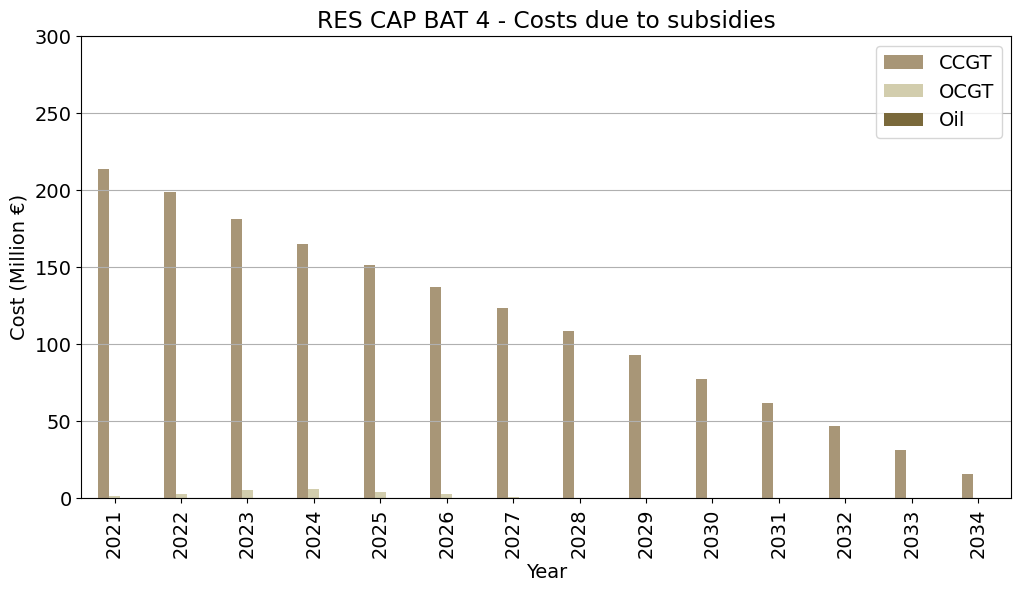

In [317]:
subsidies = get_subsidies()
cost_of_subsidies = {}

for year in years:
    for (subsidy_year, carrier), subsidy_rate in subsidies.items():
        if carrier == 'oil':
            carrier = 'Oil'
        # Check if we're looking at the correct year for the subsidy
        if subsidy_year == year:
            # Initialize a dictionary for this year if not already present
            if year not in cost_of_subsidies:
                cost_of_subsidies[year] = {}

            cost_of_subsidies[year][carrier] = 0

            # Check if the carrier is present in the production DataFrame
            if carrier in production.columns:
                # Calculate and store the cost of subsidies for this carrier in this year
                cost_of_subsidies[year][carrier] = subsidy_rate * production.loc[year,carrier]

cost_of_subsidies_df = pd.DataFrame()
for year, carriers in cost_of_subsidies.items():
    for carrier, cost in carriers.items():
        cost_of_subsidies_df.loc[year, carrier] = cost
cost_of_subsidies_df = rename_columns(cost_of_subsidies_df)
cost_of_subsidies_df.plot(kind='bar', figsize=(12, 6), color=get_colors(cost_of_subsidies_df.columns))
plt.title(case + ' - Costs due to subsidies')
plt.ylabel('Cost (Million €)')
plt.xlabel('Year')
plt.ylim(0,300)
plt.grid(axis='y')
#plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

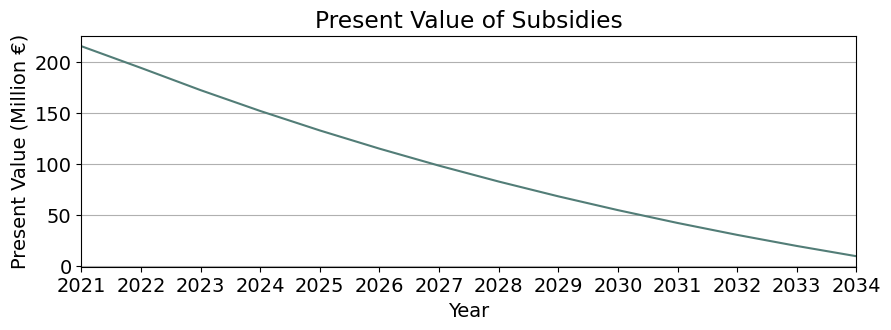

In [318]:
yearly_subsidies = cost_of_subsidies_df.sum(axis=1)
pv_subsidies = [calculate_present_value(yearly_subsidies.loc[years[i]], years[i], first_year, 0.04) for i in range(len(years))]
npv_subsidies = sum(pv_subsidies)

plt.figure(figsize=(10, 3))
plt.plot(years, pv_subsidies, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Present Value of Subsidies')
plt.xlabel('Year')
plt.ylabel('Present Value (Million €)')
plt.xlim(first_year,final_year)
#plt.ylim(0,300)
plt.grid(axis='y')
plt.show()


In [319]:
if save_to_csv:
    try:
        # Try to read the existing file
        df = pd.read_csv(path + 'result_data_RCB/subsidies.csv')
    except FileNotFoundError:
        # If file does not exist, create a new DataFrame
        df = pd.DataFrame()

    # Add the new data as a column
    df[case_path] = [npv_subsidies]

    # Write the updated DataFrame to the file
    df.to_csv(path + 'result_data_RCB/subsidies.csv', index=False)

if all_saved:
    df = pd.read_csv(path + 'result_data_RCB/subsidies.csv')

    plt.figure(figsize=(10, 6)) 

    num_scenarios = len(df.columns)
    labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
    df.columns = labels
    colors = [beige2, beige3, teal4, teal3, teal2]

    for i, column in enumerate(df.columns):
        # Calculate the positions for the current column
        positions = range(i, len(df) * len(df.columns), len(df.columns))
        plt.bar(positions, df[column], width=0.8, label=column, color=colors[i])

    # Set the title and labels
    plt.title('Total subsidies for Different Scenarios')
    plt.ylabel('Total Subsidies [billion €]')

    # Set x-ticks to be in the middle of the group of bars for each scenario
    tick_positions = range(len(df.columns) // 2, len(df) * len(df.columns), len(df.columns))
    plt.xticks(range(num_scenarios), df.columns)

    #plt.legend()
    plt.grid(axis='y')
    plt.ylim(0,8)
    plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')
    plt.show()

# else:
#     total_subsidies_series = pd.Series(total_subsidies)
#     total_subsidies_series.plot(kind='bar', figsize=(4, 4), color=teal2)
#     plt.ylabel('Total subsidies [billion €]')
#     #plt.ylim(0,18)
#     plt.xlabel(case_path)
#     plt.grid(axis='y')
#     plt.savefig(path_fig + 'subsidies.png', dpi=300, bbox_inches='tight')

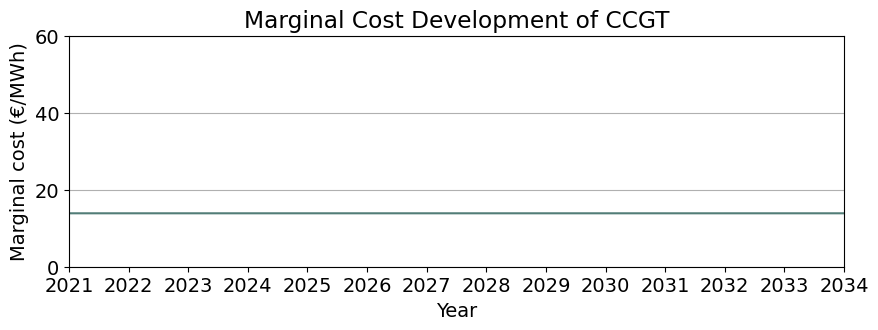

In [320]:
marginal_cost_CCGT = [get_marginal_cost(year,'CCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_CCGT, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of CCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,60)
plt.grid(axis='y')
plt.show()

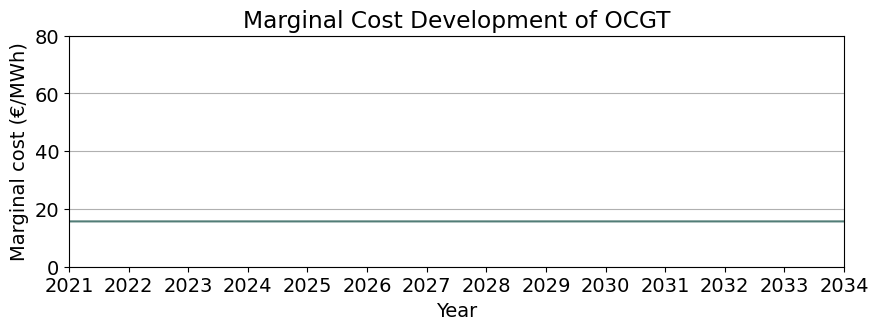

In [321]:
marginal_cost_OCGT = [get_marginal_cost(year,'OCGT') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_OCGT, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of OCGT')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,80)
plt.grid(axis='y')
plt.show()

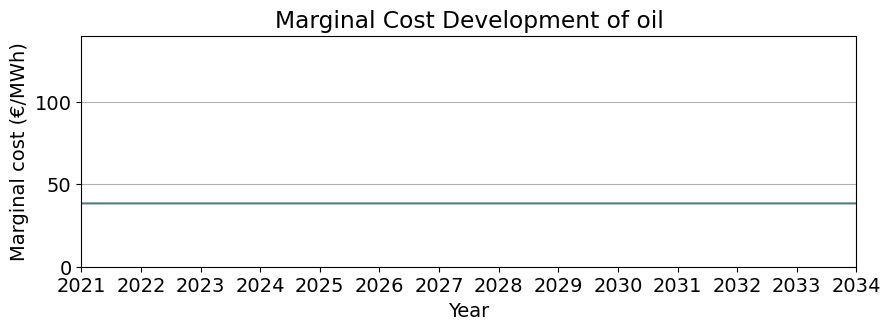

In [322]:
marginal_cost_oil = [get_marginal_cost(year,'oil') for year in years]
plt.figure(figsize=(10, 3))
plt.plot(years, marginal_cost_oil, color=teal3)
plt.xticks(years, [int(year) for year in years])
plt.title('Marginal Cost Development of oil')
plt.xlabel('Year')
plt.ylabel('Marginal cost (€/MWh)')
plt.xlim(first_year,final_year)
plt.ylim(0,140)
plt.grid(axis='y')
plt.show()

In [323]:
# discount_rate = 0.04

# lifetime = {  # example lifetimes in years
#     'hydro': 80,
#     'ror': 80,
#     'OCGT': 30,
#     'CCGT': 30,
#     'geothermal': 40,
#     'biomass': 30,
#     'oil': 30,
#     'solar': 25,
#     'onwind': 30,
#     'electrolysis': 18,
#     'fuel cell': 20,
#     'hydrogen storage': 20,
#     'H2 pipeline': 40,
#     # add lifetimes for all technologies
# }

# annual_costs_list = []

# for year in years:
#     network = networks[year]  # Adjust the path as necessary
#     stats = network.statistics()
#     # Calculate annual Capital Expenditure and Operational Expenditure for all relevant categories
#     annual_capex = 0
#     annual_opex = 0

#     for category in ['Generator', 'Load', 'StorageUnit', 'Store']:
#         if 'Capital Expenditure' in stats.columns:
#             annual_capex += stats.loc[category, 'Capital Expenditure'].sum()
#         if 'Operational Expenditure' in stats.columns:
#             annual_opex += stats.loc[category, 'Operational Expenditure'].sum()
    
#     annual_costs_list.append((annual_capex + annual_opex)/1e9)


# annual_costs_npv = npv_of_costs(annual_costs_list, discount_rate)
# annual_costs_df = pd.DataFrame({'Year': years, 'Cost': annual_costs_list})

# if save_to_csv:
#     try:
#         df = pd.read_csv(path + 'result_dfs/annual_costs.csv')
#     except FileNotFoundError:
#         df = pd.DataFrame()
#     df[case_path] = annual_costs_df['Cost']
#     df.to_csv(path + 'result_dfs/annual_costs.csv', index=False)

# if all_saved:
#     df = pd.read_csv(path + 'result_dfs/annual_costs.csv')
#     df = df.set_index('Year')

#     labels = ['Base', 'Base Cap', 'Sudden', 'Sudden Cap', 'Gradual']
#     df.columns = labels
#     colors = [beige2, beige3, teal4, teal3, teal2]

#     plt.figure(figsize=(10, 6))  # Adjust the size as needed
#     for column in df.columns:
#         df[column].plot(label=column, color=colors[labels.index(column)])
#     plt.title('Annual Costs for Different Scenarios')
#     plt.xlabel('Year')
#     plt.ylabel('Annual Costs [billion €]')
#     plt.legend()
#     plt.grid(axis='y')
#     plt.ylim(0,10)
#     plt.savefig(path_fig + 'annual_cost.png', dpi=300, bbox_inches='tight')
#     plt.show()


# else:
#     plt.figure(figsize=(10, 5))
#     plt.plot(annual_costs_df['Year'], annual_costs_df['Cost'], color=teal2)
#     plt.xticks(years, [int(year) for year in years])
#     plt.title('Base - Annual Costs of the Energy System Over Time')
#     plt.ylabel('Cost [billion €]')
#     plt.xlabel('Year')
#     plt.grid(axis='y')
#     plt.ylim(0,1)
#     plt.savefig(path_fig + 'annual_cost.png', dpi=300, bbox_inches='tight')

In [324]:
# n = networks[final_year]
# capital_cost_gen = n.generators.groupby('carrier').capital_cost.mean().drop('load')
# capital_cost_gen_series = pd.Series(capital_cost_gen, index=capital_cost_gen.index)
# capital_cost_storage = n.storage_units.groupby('carrier').capital_cost.mean()
# capital_cost_storage_series = pd.Series(capital_cost_storage, index=capital_cost_storage.index)
# capital_cost = pd.concat([capital_cost_gen, capital_cost_storage])

# grouped_cap_change_B = get_new_installed(years)

# i =0.04
# data_add_cost = {}
# carriers = [col for col in grouped_cap_change_B.columns if col != year]
# for carrier in carriers:
#     carrier_values = []

#     for y in np.arange(first_year, final_year+1):
#         value = 0
#         for rest in np.arange(final_year+1-y):
#             if rest > 0:
#                 value += (grouped_cap_change_B[carrier].loc[y] * capital_cost[carrier])/((1+i)**rest)
            
#         carrier_values.append(value)
#     data_add_cost[carrier] = carrier_values

# add_cost_B = pd.DataFrame(data_add_cost, index=np.arange(first_year, final_year+1))

In [325]:
# objective_value_list_B = []
# for y in range(first_year,final_year):
#     net=networks[y]
#     objective_value_list_B.append(net.objective)

# data={"year":[],"total_costs":[]}
# for y in np.arange(first_year,final_year):
#     data["year"].append(y)
#     data["total_costs"].append(objective_value_list_B[y-first_year]/((1+i)**(y-first_year))+ add_cost_B.sum(axis = 1)[y]/((1+i)**(y-first_year))) #objective_value_B[y]+

# total_costs_B=pd.DataFrame(data)
# total_costs_B.index=total_costs_B["year"]
# total_costs_B.drop("year",axis=1,inplace=True)

In [326]:
# (total_costs_B['total_costs']/1000000).plot(figsize=(11, 4),color = teal2, linewidth = 4, zorder = 2, label = 'Baseline')
# plt.ylabel('Yearly costs [million €]',fontsize = 18)
# plt.xlabel('Year',fontsize = 18)
# plt.grid(axis='y')
# plt.xlim(first_year,final_year)
# #plt.ylim(0,400)
# plt.legend(frameon = False, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4)


In [327]:
# total_cost = total_costs_B.sum() / 1e9
# total_cost_series = pd.Series(total_cost.iloc[0], index=[''])
# total_cost_series.plot(kind='bar', figsize=(4, 4), color=teal2)
# plt.ylabel('Total cost [billion €]')
# #plt.ylim(0,18)
# plt.xlabel(case)
# plt.grid(axis='y')
# plt.show()